In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import (preprocess_input)
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# === CONFIG ===
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BASE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_DATASET_F1"
CLASSES = ["BLIGHT", "BLAST", "BROWNSPOT", "HEALTHY"]
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # ✅ Smaller for BN layers
EPOCHS = 60
LEARNING_RATE = 1e-5  # ✅ Lower for frozen backbone

# === Load filepaths & labels ===
all_filepaths, all_labels = [], []
for idx, class_name in enumerate(CLASSES):
    aug_path = os.path.join(BASE_PATH, class_name, "augmented")
    files = glob.glob(os.path.join(aug_path, "*.jpg")) + \
            glob.glob(os.path.join(aug_path, "*.jpeg")) + \
            glob.glob(os.path.join(aug_path, "*.png"))
    all_filepaths.extend(files)
    all_labels.extend([idx] * len(files))

print(f"✅ Total images found: {len(all_filepaths)}")

# === tf.data.Dataset ===
filepaths_ds = tf.data.Dataset.from_tensor_slices(all_filepaths)
labels_ds = tf.data.Dataset.from_tensor_slices(all_labels)
ds = tf.data.Dataset.zip((filepaths_ds, labels_ds)).shuffle(len(all_filepaths), seed=SEED)

train_size = int(0.8 * len(all_filepaths))
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)

print(f"✅ Train samples: {train_size} | Val samples: {len(all_filepaths) - train_size}")

✅ Total images found: 32460
✅ Train samples: 25968 | Val samples: 6492


In [2]:
# === Color Jitter ===
def color_jitter(image):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    return tf.clip_by_value(image, 0.0, 255.0)  # Important: keep in original range if using preprocess_input


# === GridMask ===
def grid_mask(image, d_min=50, d_max=100, ratio=0.5):
    h, w, _ = image.shape
    d = tf.random.uniform([], d_min, d_max, dtype=tf.int32)
    l = tf.cast(tf.cast(d, tf.float32) * ratio, tf.int32)

    mask = tf.ones([h, w], dtype=tf.float32)

    for i in range(0, h, d):
        for j in range(0, w, d):
            y1 = i
            y2 = tf.minimum(i + l, h)
            x1 = j
            x2 = tf.minimum(j + l, w)

            y_range = tf.range(y1, y2)
            x_range = tf.range(x1, x2)
            yy, xx = tf.meshgrid(y_range, x_range, indexing='ij')
            indices = tf.stack([yy, xx], axis=-1)
            indices = tf.reshape(indices, [-1, 2])

            mask = tf.tensor_scatter_nd_update(
                mask,
                indices,
                tf.zeros([(y2 - y1) * (x2 - x1)], dtype=tf.float32)
            )

    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.tile(mask, [1, 1, 3])
    return image * mask


# === Image Processor ===
def process_img(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)

    img = color_jitter(img)  # keep values 0-255
    img = grid_mask(img)  # keep values 0-255

    img = preprocess_input(img)  # ✅ For ResNet50: scale to [-1, 1] the same way as pretraining

    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

In [3]:
# === Final Pipeline ===
train_ds = train_ds.map(process_img).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_img).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet import preprocess_input

# Reload dataset & pipeline same as Phase 1
# (Reuse `process_img`, `cutmix`, etc.)

model = load_model(r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\Xception_Phase1_Gridmask.h5")
for layer in model.layers:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)


# === Learning rate logger ===
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        # If using a scheduler, it might be a callable or tensor
        if hasattr(lr, '__call__'):
            lr = lr(self.model.optimizer.iterations)
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f"📉 Learning rate at epoch {epoch + 1}: {lr:.6f}")


# === Compute class weights ===
y_train_int = np.argmax(np.concatenate([labels.numpy() for _, labels in train_ds.unbatch().batch(BATCH_SIZE)]), axis=1)
class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASSES)),
    y=y_train_int
)))
print("✅ Computed class weights:", class_weights)

✅ Computed class weights: {0: 0.9976947902259106, 1: 1.0065116279069768, 2: 0.9925087907047851, 3: 1.003400309119011}


In [4]:
# === Train ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True), LearningRateLogger()],
    class_weight=class_weights
)

Epoch 1/60
📉 Learning rate at epoch 1: 0.000010====] - ETA: 0s - loss: 0.6527 - accuracy: 0.7856   
3246/3246 [==============================] - 552s 168ms/step - loss: 0.6527 - accuracy: 0.7856 - val_loss: 0.5373 - val_accuracy: 0.8474
Epoch 2/60
📉 Learning rate at epoch 2: 0.000010====] - ETA: 0s - loss: 0.5324 - accuracy: 0.8514   
3246/3246 [==============================] - 590s 182ms/step - loss: 0.5324 - accuracy: 0.8514 - val_loss: 0.4692 - val_accuracy: 0.8817
Epoch 3/60
📉 Learning rate at epoch 3: 0.000010====] - ETA: 0s - loss: 0.4723 - accuracy: 0.8837   
3246/3246 [==============================] - 544s 167ms/step - loss: 0.4723 - accuracy: 0.8837 - val_loss: 0.4203 - val_accuracy: 0.9047
Epoch 4/60
📉 Learning rate at epoch 4: 0.000010====] - ETA: 0s - loss: 0.4353 - accuracy: 0.8993   
3246/3246 [==============================] - 568s 175ms/step - loss: 0.4353 - accuracy: 0.8993 - val_loss: 0.4114 - val_accuracy: 0.9076
Epoch 5/60
📉 Learning rate at epoch 5: 0.000010====]

1/1 [==============================] - 0s 23ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      BLIGHT       1.00      1.00      1.00      1605
       BLAST       1.00      0.99      0.99      1596
   BROWNSPOT       0.99      1.00      1.00      1612
     HEALTHY       1.00      0.99      0.99      1679

    accuracy                           1.00      6492
   macro avg       1.00      1.00      1.00      6492
weighted avg       1.00      1.00      1.00      6492



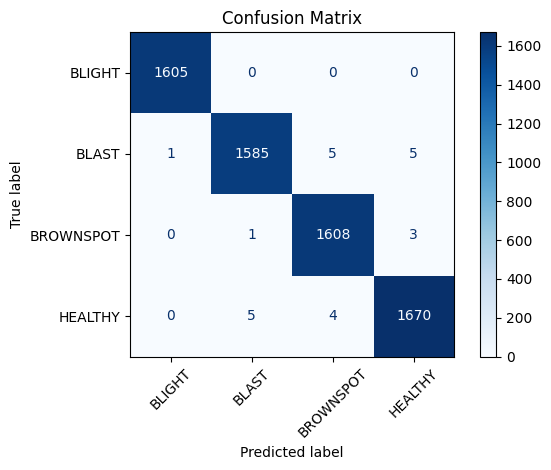

✅ Model saved at: C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\Xception_Phase2_Gridmask.h5


In [5]:
# === Evaluate ===
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Save ===
SAVE_PATH = r"C:\Users\ADITYA DAS\Desktop\Machine Learning\CP_MODEL\Xception_Phase2_Gridmask.h5"
model.save(SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")
